In [1]:
import os
import argparse
import numpy as np
import six
import six.moves.cPickle as pickle
import matplotlib.pyplot as plt
import cv2

import chainer
import chainer.functions as F
from chainer import cuda
from chainer import optimizers
#from chainer import computational_graph as c

In [2]:
%matplotlib inline

###define parameters

parser  = argparse.ArgumentParser(description='cnn for neuro classification')
parser.add_argument('--gpu','-g',default=-1,type=int,
                                       help='GPU ID (negative value indicates CPU)')
parser.add_argument('--arch','-a',default='cnn3')
parser.add_argument('--batchs','-B',default=30,type=int,
                                      help = 'learning minibatch size')
parser.add_argument('--epoch','-E',default=20, type=int)
parser.add_argument('--out', '-o',default='model',
                                      help = "Path to save model")
args = parser.parse_args()

In [3]:
n_epoch =200
batchsize=25
gpu_flag = 0

N = 900#size of train data

###Get image dataset

In [4]:
dpath=os.path.abspath("")
foldername = "/dataset"

x_data = np.load(dpath+foldername+"/x_data1.npy")
t_data = np.load(dpath+foldername+"/t_data1.npy")
mean = np.load(dpath+foldername+"/mean.npy")

In [5]:
x_data = x_data - mean[:,:,:,np.newaxis]

x_data = x_data.transpose(3,0,1,2).astype(np.float32)
t_data = t_data.transpose(3,0,1,2).astype(np.float32)

print x_data.shape
print t_data.shape
print len(x_data)

N_test = len(x_data)-N

print N_test

(1000, 1, 255, 255)
(1000, 1, 255, 255)
1000
100


In [6]:
np.min(x_data)

-0.41072941

###Separate data into train and test

In [7]:
#shuffle the data
shuffle = np.random.permutation(len(t_data))

x_data = np.asarray(x_data[shuffle,:,:,:])
t_data = np.asarray(t_data[shuffle,:,:,:])

In [8]:
#separate data
x_train, x_test = np.split(x_data,[N],axis=0)
t_train, t_test = np.split(t_data,[N],axis=0)

print x_train.shape, t_train.shape

(900, 1, 255, 255) (900, 1, 255, 255)


###Prepare model

In [28]:
import segmentation
model = segmentation.CNN_segment3()

###GPU setup

In [29]:
if gpu_flag >= 0:
    cuda.check_cuda_available()

xp = cuda.cupy if gpu_flag >=0 else np
    
if gpu_flag >= 0:
    cuda.get_device(gpu_flag).use()
    model.to_gpu()

###Setup optimizer(Adam)

In [30]:
optimizer = optimizers.Adam()
optimizer.setup(model)

###Learning loop

In [31]:
train_loss = []
test_loss = []

for epoch in six.moves.range(1,n_epoch +1):
    print 'epoch: ', epoch
    
    #training
    perm = np.random.permutation(N)
    sum_loss = 0
    for i in six.moves.range(0,N,batchsize):
        x_batch = xp.asarray(x_train[perm[i:i + batchsize]])
        t_batch = xp.asarray(t_train[perm[i:i + batchsize]])
        
        optimizer.zero_grads()
        loss = model.forward(x_batch, t_batch)
        loss.backward()
        optimizer.update()
        
#        if epoch ==1 and i ==0:
#            with open("graph.dot","w") as o:
#                o.write(c.build_computational_graph((loss, )).dump())
#            with open("graph.wo_split.dot","w") as o:
#                g = c.bulid_computational_graph((loss, ), remove_split=True)
#                o.write(g.dump())
                
#            print "graph generated"
        
        #print loss.data


        sum_loss += float(loss.data)*t_batch.shape[0]

        
    train_loss.append([epoch,sum_loss/N])
    
    print "train mean loss={}".format(sum_loss/N)
    
    #evaluation
    sum_loss = 0
    for i in six.moves.range(0,N_test,batchsize):
        x_batch = xp.asarray(x_test[i:i+batchsize])
        t_batch = xp.asarray(t_test[i:i+batchsize])
        
        loss = model.forward(x_batch, t_batch, train=False)
        
        sum_loss += float(loss.data)*t_batch.shape[0]
        
    test_loss.append([epoch,sum_loss/N_test])

    print "test mean loss={}".format(sum_loss/N_test)
    
train_loss = np.asarray(train_loss)
test_loss = np.asarray(test_loss)

epoch:  1
train mean loss=0.206677246011
test mean loss=0.228950701654
epoch:  2
train mean loss=0.201947336396
test mean loss=0.232668474317
epoch:  3
train mean loss=0.202099508709
test mean loss=0.233494330198
epoch:  4
train mean loss=0.201753888279
test mean loss=0.233430594206
epoch:  5
train mean loss=0.20131021945
test mean loss=0.23068626225
epoch:  6
train mean loss=0.201312883033
test mean loss=0.228551656008
epoch:  7
train mean loss=0.201315275911
test mean loss=0.231829363853
epoch:  8
train mean loss=0.201364608275
test mean loss=0.229205921292
epoch:  9
train mean loss=0.201162660701
test mean loss=0.230182752013
epoch:  10
train mean loss=0.201136118836
test mean loss=0.230457291007
epoch:  11
train mean loss=0.201177443481
test mean loss=0.229999888688
epoch:  12
train mean loss=0.201582070026
test mean loss=0.234066523612
epoch:  13
train mean loss=0.201351177361
test mean loss=0.229334395379
epoch:  14
train mean loss=0.201126277861
test mean loss=0.229762297124
epo

###Plot&save graph

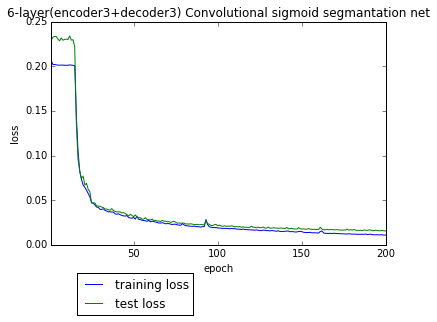

In [32]:
fig, ax1 = plt.subplots()
ax1.plot(train_loss[:, 0], train_loss[:, 1], label='training loss')
ax1.plot(test_loss[:, 0], test_loss[:, 1], label='test loss')
ax1.set_xlim([1, len(train_loss)])
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')


ax1.legend(bbox_to_anchor=(0.25, -0.1), loc=9)
plt.title("6-layer(encoder3+decoder3) Convolutional sigmoid segmantation net")
plt.savefig(dpath+"/figs/segmentation3_sig", bbox_inches='tight')

plt.show()


###Save final model

In [33]:
pickle.dump(model, open('sig_segment3', 'wb'),-1)

###Test segmentration

In [34]:
model='sig_segment3'
model=pickle.load(open(model,'rb'))

In [35]:
num=28

####raw data

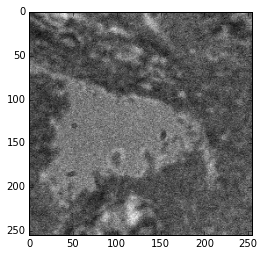

In [36]:
plt.imshow(x_test[num,0,:],cmap = plt.get_cmap('gray'))

####ground truth

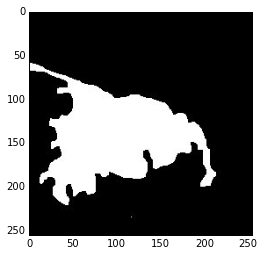

In [37]:
plt.imshow(t_test[num,0,:],cmap = plt.get_cmap('gray'))

####Predictied map

In [38]:
predict = np.array([]).astype(np.float32) 
for i in xrange(len(x_test)):
    hoge = xp.asarray(x_test[i:i+1])
    hoge=cuda.to_cpu(model.predict(hoge))
    hoge=np.array(hoge)
    if i==0:
        predict = hoge
    else:
        predict = np.concatenate((predict, hoge),axis=0)

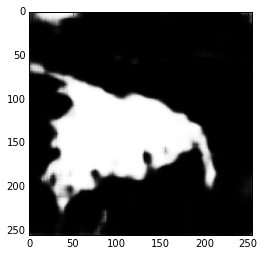

In [39]:
plt.imshow(predict[num,0,:],cmap = plt.get_cmap('gray'))

###Save result

In [40]:
np.save(dpath+"/result/rawimage_sig3.npy",x_test)
np.save(dpath+"/result/groundtruth_sig3.npy",t_test)
np.save(dpath+"/result/predict_sig3.npy",predict)